In [10]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [11]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: (frame, calibration)
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

EOFError: Ran out of input

In [4]:
# make sure to handle NaN values

im = Image.fromarray(test_data[5000])
im2 = Image.fromarray(training_data[5000][0])
im.show()
im2.show()

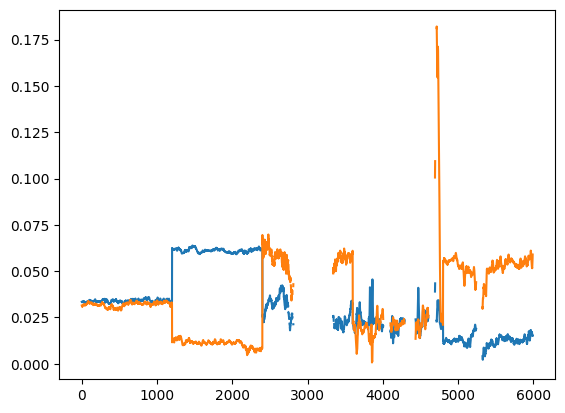

In [5]:
radians = training_data[:,1]
r1 = [r1 for r1, _ in radians]
r2 = [r2 for _, r2 in radians]
x = [i for i in range(len(radians))]

plt.plot(x, r1, label='r1')
plt.plot(x, r2, label='r2')

In [6]:
# Playing around with the data
frame1 = test_data[0]
frame1[0,0]
# test = frame1[:, :, 2].squeeze()
# df = pd.DataFrame(test[0:100,0:100])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient()

array([143,  91,  49], dtype=uint8)

In [48]:
# CODE IN THIS BLOCK IS FROM https://github.com/commaai/openpilot/tree/master/common/transformations

# TESTING
focal_length = 910.0
frame_size = (1164, 874)

# aka 'K' aka camera_frame_from_view_frame
calib_challenge_intrinsics = np.array([
  [focal_length,  0.0,  float(frame_size[0])/2],
  [0.0,  focal_length,  float(frame_size[1])/2],
  [0.0,  0.0,                              1.0]])


def normalize(img_pts, intrinsics=calib_challenge_intrinsics):
  # normalizes image coordinates
  # accepts single pt or array of pts
  intrinsics_inv = np.linalg.inv(intrinsics)
  img_pts = np.array(img_pts)
  input_shape = img_pts.shape
  img_pts = np.atleast_2d(img_pts)
  img_pts = np.hstack((img_pts, np.ones((img_pts.shape[0], 1))))
  img_pts_normalized = img_pts.dot(intrinsics_inv.T)
  img_pts_normalized[(img_pts < 0).any(axis=1)] = np.nan
  return img_pts_normalized[:, :2].reshape(input_shape)


def get_calib_from_vp(vp):
  vp_norm = normalize(vp)
  yaw_calib = np.arctan(vp_norm[0])
  pitch_calib = -np.arctan(vp_norm[1]*np.cos(yaw_calib))
  roll_calib = 0
  return roll_calib, pitch_calib, yaw_calib

# Test to add for going from vp -> _roll, pitch, yaw: make the vp the center of the camera and see if 
# all angles are 0

# inserting a single point
test_vp = np.array([frame_size[0]/2, frame_size[1]/2])
roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vp)
assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"

# inserting a list of points
# test_vp = np.array([frame_size[0]/2, frame_size[1]/2])
# test_vps = [test_vp, test_vp, test_vp, test_vp]
# roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vps)
# print(len(pitch_calib))
# assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"


TypeError: object of type 'numpy.float64' has no len()

In [71]:
# Tested assumption that when vp = center of img, the pitch = yaw = 0.0 would yield 100% MSE according to eval.py (it does)

# vid[0] is the name of the file, vid[1] is the video data
vid_5 = ('unlabeled/5.txt', test_data[:1200])
vid_6= ('unlabeled/6.txt', test_data[1200:2400])
vid_7 = ('unlabeled/7.txt', test_data[2400:3600])
vid_8 = ('unlabeled/8.txt', test_data[3600:4800])
vid_9 = ('unlabeled/9.txt', test_data[4800:5996])
test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

def generate_and_write_test_labels(vid):
  with open(vid[0], 'w') as f:
      for frame in vid[1]:
          vp = test_vp # TODO: replace with function to determine the vp from the frame!
          _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
          f.write(f'{pitch_calib} {yaw_calib}\n')
      f.close()
    
for test_video in test_videos:
    generate_and_write_test_labels(test_video)

# rot means rotation matrix
# print(len(vid_1))

# # 0-3 are 1200 frames, 4 is 1196
# def get_video_label_from_frame_idx(idx):
#     if idx < 1200: video = 5
#     elif idx < 2400: video = 6
#     elif idx < 3600: video = 7
#     elif idx < 4800: video = 8
#     else: video = 9
#     return f'{video}.txt'

# def calc_test_calib_labels():
#     for idx, frame in enumerate(test_data):
#         video_label = get_video_label_from_frame_idx(idx)
        
#     # _roll, pitch, yaw = get_calib_from_vp(test_vp)
    

# print(get_video_label_from_frame_idx(0))
# print(get_video_label_from_frame_idx(1201))
# print(get_video_label_from_frame_idx(2401))
# print(get_video_label_from_frame_idx(3601))
# print(get_video_label_from_frame_idx(4801))
# # calc_test_calib_labels()


: 

In [ ]:
# Now, if I move along each video frame and calculate the vp, I should be able to get the calibration

# https://medium.com/mlearning-ai/recovering-extrinsic-matrix-rotation-with-vanishing-points-b1ea97f02504
# (section: Recovering Extrinsic Matrix (Rotation) with Estimated Vanishing Points)

# https://www.geeksforgeeks.org/opencv-real-time-road-lane-detection/